In [14]:
environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #to suppress all tensorflow warnings
chdir(r'C:\Users\Deepika\CS5000\Model_Callbacks_Checkpoint_SGD')

from os import environ, chdir
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers, callbacks
from numpy import set_printoptions
set_printoptions(precision=4,suppress=True)
from keras.models import load_model
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D 
from keras.layers import Dropout, Flatten, Dense 
import shutil
import os 
import random

In [2]:
pwd

'C:\\Users\\Deepika\\CS5000\\Model_Callbacks_Checkpoint_SGD'

In [9]:
fresh_dirpath, fresh_dirnames, fresh_images = next(os.walk('Dataset/AppleImages/fresh'))
rotten_dirpath, rotten_dirnames, rotten_images = next(os.walk('Dataset/AppleImages/rotten'))

#Split ratio 
train_size = 0.8 

#Main source folder with two folders namely fresh and rotten
src_folder = 'Dataset/AppleImages/'

# Make sure we remove any existing folders and start from a clean slate
shutil.rmtree(src_folder+'Train/fresh/', ignore_errors=True)
shutil.rmtree(src_folder+'Train/rotten/', ignore_errors=True)
shutil.rmtree(src_folder+'Test/fresh/', ignore_errors=True)
shutil.rmtree(src_folder+'Test/rotten/', ignore_errors=True)

#create new empty train and test folders
os.makedirs(src_folder+'Train/fresh/')
os.makedirs(src_folder+'Train/rotten/')
os.makedirs(src_folder+'Test/fresh/')
os.makedirs(src_folder+'Test/rotten/')

#Total number of fresh and rotten images
num_fresh_images = len(fresh_images)
num_rotten_images = len(rotten_images)

#Split fresh images into training images and test images with given split ratio
num_fresh_images_train = int(train_size * num_fresh_images)
num_fresh_images_test = num_fresh_images - num_fresh_images_train

#Split rotten images into training images and test images with given split ratio
num_rotten_images_train = int(train_size * num_rotten_images)
num_rotten_images_test = num_rotten_images - num_rotten_images_train

# Randomly assign fresh images to train and test
fresh_train_images = random.sample(fresh_images, num_fresh_images_train)
for img in fresh_train_images:
    shutil.copy(src=src_folder+'fresh/'+img, dst=src_folder+'Train/fresh/')
#1670 images changed to #1252

fresh_test_images  = [img for img in fresh_images if img not in fresh_train_images]
for img in fresh_test_images:
    shutil.copy(src=src_folder+'fresh/'+img, dst=src_folder+'Test/fresh/')
#418 images changed to #836

#Randomly assign rotten images to train and test
rotten_train_images = random.sample(rotten_images, num_rotten_images_train)
for img in rotten_train_images:
    shutil.copy(src=src_folder+'rotten/'+img, dst=src_folder+'Train/rotten/')


rotten_test_images  = [img for img in rotten_images if img not in rotten_train_images]
for img in rotten_test_images:
    shutil.copy(src=src_folder+'rotten/'+img, dst=src_folder+'Test/rotten/')

    
print("Number of training fresh images",num_fresh_images_train)
print("Number of training rotten images",num_rotten_images_train)
print("Number of Training images ",num_fresh_images_train+num_rotten_images_train)
print("********************************************************************")
print("Number of testing fresh images",num_fresh_images_test)
print("Number of testing rotten images",num_rotten_images_test)
print("Number of Testing images ",num_fresh_images_test+num_rotten_images_test )

Number of training fresh images 1670
Number of training rotten images 2354
Number of Training images  4024
********************************************************************
Number of testing fresh images 418
Number of testing rotten images 589
Number of Testing images  1007


In [10]:
#hyperparameters
FILTER_SIZE = 3 
NUM_FILTERS = 32 
INPUT_SIZE  = 64
MAXPOOL_SIZE = 2 
BATCH_SIZE = 32 

#Steps per epoch is based on Training so in total we have 1670 fresh and 2354 rotten images =4024/batch size=125.75 =>126
STEP_PER_TRAIN = round((num_rotten_images_train+num_fresh_images_train)/BATCH_SIZE)
STEP_PER_TEST= round((num_rotten_images_test+num_fresh_images_test)/BATCH_SIZE)


In [11]:
print("Training step size is {0},Testing step size {1}".format(STEP_PER_TRAIN,STEP_PER_TEST))

Training step size is 126,Testing step size 31


In [12]:
#Loading Data
#We are just gonna load the images along with data augmentation
training_data_generator = ImageDataGenerator(rescale = 1./255,
                                             shear_range = 0.2,
                                             zoom_range = 0.2,
                                             horizontal_flip = True)#AUGMENTATION DONE HERE SINCE THIS IS TRAINING IMAGE

training_set = training_data_generator.flow_from_directory('Dataset/AppleImages/Train/',
                                                           target_size=(INPUT_SIZE,INPUT_SIZE),                                                    
                                                           batch_size=BATCH_SIZE,                                                    
                                                           class_mode='binary')

testing_data_generator = ImageDataGenerator(rescale = 1./255)#NO MUCH AUGMENTATION DONE HERE-NO CHANGE

test_set = testing_data_generator.flow_from_directory('Dataset/AppleImages/Test/',                               
                                                      target_size=(INPUT_SIZE,INPUT_SIZE),                        
                                                      batch_size=BATCH_SIZE,                                   
                                                      class_mode = 'binary')

Found 4024 images belonging to 2 classes.
Found 1007 images belonging to 2 classes.


In [17]:
import warnings
warnings.filterwarnings("ignore")
environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#Model 4 (conv+relu+maxpool)(conv+relu+maxpool)(Dense 128)(Dense 1)
model = Sequential() 

model.add(Conv2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE),  
                 input_shape = (INPUT_SIZE, INPUT_SIZE, 3),                
                 activation = 'relu')) 

#we add a max pooling layer:
model.add(MaxPooling2D(pool_size = (MAXPOOL_SIZE, MAXPOOL_SIZE))) 

#Repeat 2nd convolutional layer
model.add(Conv2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE),  
                 input_shape = (INPUT_SIZE, INPUT_SIZE, 3),                
                 activation = 'relu')) 

#we add a max pooling layer:
model.add(MaxPooling2D(pool_size = (MAXPOOL_SIZE, MAXPOOL_SIZE))) 

#flatten multi dimensional array to single to 1dimensional vector
model.add(Flatten())

#add a fully connected layer with 128 nodes:
model.add(Dense(units = 128, activation = 'relu'))

#one last fully connected layer to our model:
model.add(Dense(units = 1, activation = 'sigmoid')) 



# Model Loss function and Optimizer SGD with lr =0.15 method 
compile = model.compile(optimizer=optimizers.sgd(lr=0.15), loss='binary_crossentropy',
                           metrics=['accuracy'])


In [18]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total para

In [19]:
# Settting Callbacks
check_p = callbacks.ModelCheckpoint(filepath='FruitStatus_cnn_{val_acc:.2f}.h5',
                                    monitor='val_acc', verbose=1,
                                    save_best_only=True, save_weights_only=False)


#2nd Callback
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=3,
                                        verbose=1, cooldown=2)

#list two callbacks 
callb_l = [check_p, reduce_lr]

In [21]:
#Fit model
#fit_generator deals directly with images 
history = model.fit_generator(generator=training_set, 
                             steps_per_epoch=STEP_PER_TRAIN, 
                             epochs=50, verbose=1,
                             callbacks=callb_l, 
                             validation_data=test_set, 
                             validation_steps=STEP_PER_TEST)



Epoch 1/50
126/126 [==============================] - 29s 230ms/step - loss: 0.6861 - acc: 0.5820 - val_loss: 0.6776 - val_acc: 0.5857

Epoch 00001: val_acc improved from -inf to 0.58569, saving model to FruitStatus_cnn_0.59.h5
Epoch 2/50
126/126 [==============================] - 24s 194ms/step - loss: 0.6737 - acc: 0.5964 - val_loss: 0.6800 - val_acc: 0.5815

Epoch 00002: val_acc did not improve from 0.58569
Epoch 3/50
126/126 [==============================] - 25s 195ms/step - loss: 0.6714 - acc: 0.5907 - val_loss: 0.6814 - val_acc: 0.5836

Epoch 00003: val_acc did not improve from 0.58569
Epoch 4/50
126/126 [==============================] - 25s 198ms/step - loss: 0.6764 - acc: 0.5845 - val_loss: 0.6660 - val_acc: 0.5856

Epoch 00004: val_acc did not improve from 0.58569

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.14250000566244125.
Epoch 5/50
126/126 [==============================] - 26s 203ms/step - loss: 0.6664 - acc: 0.5975 - val_loss: 0.6868 - val_acc: 0.5856

In [23]:
# Loading best Model
my_model = load_model(filepath=r'C:\Users\Deepika\CS5000\Model_Callbacks_Checkpoint_SGD\FruitStatus_cnn_0.99.h5')

# Parameters: Weights and Biases
print('Fruit_Status_CNN last layer bias:')
print(my_model.get_weights()[-1])
print('Fruit_Status_CNN last layer weights:')
print(my_model.get_weights()[-2])

Fruit_Status_CNN last layer bias:
[-0.5858]
Fruit_Status_CNN last layer weights:
[[ 0.0337]
 [-0.3784]
 [-0.3113]
 [ 0.0095]
 [-0.384 ]
 [-0.1373]
 [-0.3862]
 [ 0.1123]
 [ 0.0669]
 [-0.2031]
 [ 0.2189]
 [ 0.2736]
 [-0.0652]
 [ 0.1827]
 [-0.2007]
 [ 0.0759]
 [ 0.0825]
 [-0.1931]
 [-0.5113]
 [ 0.0917]
 [ 0.0705]
 [ 0.1971]
 [-0.1184]
 [-0.2954]
 [-0.2396]
 [-0.3844]
 [ 0.2199]
 [-0.2247]
 [ 0.4313]
 [ 0.1208]
 [-0.1383]
 [ 0.1679]
 [ 0.0865]
 [-0.3672]
 [-0.081 ]
 [-0.1232]
 [ 0.0596]
 [-0.2494]
 [-0.0695]
 [-0.0975]
 [-0.0821]
 [-0.2538]
 [ 0.1669]
 [-0.129 ]
 [-0.3372]
 [ 0.0423]
 [-0.3057]
 [-0.6299]
 [ 0.079 ]
 [-0.2573]
 [-0.0583]
 [-0.2519]
 [-0.23  ]
 [ 0.2152]
 [ 0.0625]
 [ 0.2435]
 [-0.5728]
 [-0.314 ]
 [-0.1856]
 [ 0.0936]
 [-0.2879]
 [-0.2592]
 [-0.1485]
 [ 0.0185]
 [ 0.1603]
 [-0.0662]
 [ 0.195 ]
 [ 0.1209]
 [ 0.1336]
 [-0.1057]
 [ 0.154 ]
 [ 0.0086]
 [ 0.0843]
 [ 0.1496]
 [-0.3472]
 [-0.2777]
 [-0.2308]
 [-0.5261]
 [ 0.1986]
 [ 0.0588]
 [-0.0358]
 [-0.2237]
 [ 0.1599]
 [ 0.0

In [27]:
#Model Evaluation using folder containing images saved in a folder.this folder has fresh and rotten in two folders 
#dont modify image just rescale them
eval_idg=ImageDataGenerator(rescale=1. / 255)#no need image augmentation

#pull images from test folder which has 5 each for respective class .Thus batch size is 10
eval_g=eval_idg.flow_from_directory(directory=r'C:\Users\Deepika\CS5000\Model_Callbacks_Checkpoint_SGD\Dataset\AppleImages\cnn_apple_realtest_internet',
                                    target_size=(INPUT_SIZE,INPUT_SIZE),                                                    
                                    class_mode='binary',    
                                    batch_size=10,#number of images in cnn_apple_realtest folder
                                    shuffle=False)#we are going to pull images from one class and next class is used 

#apply test over 10 images at once 
(eval_loss,eval_acc)=my_model.evaluate_generator(generator=eval_g,steps=1)
print('Evaluation loss over Test dataset is :{:.4f}'.format(eval_loss))
print('Evaluation accuracy over Test dataset is :{:4.2f}%'.format(eval_acc*100))
#print(eval_loss,eval_acc)

Found 10 images belonging to 2 classes.
Evaluation loss over Test dataset is :0.1344
Evaluation accuracy over Test dataset is :90.00%


In [28]:
#Individual Prediction
#we are using same test dataset so make use of same eval_idg,eval_g
pred_idg=eval_idg
pred_g=eval_g

#10 individual prediction same time
pred=my_model.predict_generator(generator=pred_g,steps=1)#go though one pciture at a time

print('\n')
print(pred_g.filenames,'\n')
print(pred_g.class_indices,'\n')
print(pred[0:5],'\n')
print(pred[5:10],'\n')

print(pred[0:5]<0.5,'\n')
print(pred[5:10]>0.5,'\n')




['fresh\\fresh_internet_1.jpg', 'fresh\\fresh_internet_2.jpg', 'fresh\\fresh_internet_3.jpg', 'fresh\\fresh_internet_4.jpg', 'fresh\\fresh_internet_5.jpg', 'rotten\\rotten_internet_1.jpg', 'rotten\\rotten_internet_2.jpg', 'rotten\\rotten_internet_3.jpg', 'rotten\\rotten_internet_4.jpg', 'rotten\\rotten_internet_5.jpg'] 

{'fresh': 0, 'rotten': 1} 

[[0.0953]
 [0.0026]
 [0.    ]
 [0.    ]
 [0.    ]] 

[[1.    ]
 [1.    ]
 [1.    ]
 [1.    ]
 [0.2892]] 

[[ True]
 [ True]
 [ True]
 [ True]
 [ True]] 

[[ True]
 [ True]
 [ True]
 [ True]
 [False]] 



# Predict single rotten image 

In [140]:
filename='Dataset/AppleImages/cnn_apple_realtest_internet/rotten/rotten_internet_7.jpg'
#filename='Dataset/AppleImages/cnn_apple_realtest_internet/fresh/fresh_internet_3.jpg'



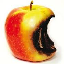

In [141]:
#Trying single image
test_image = image.load_img(filename, target_size = (64, 64,3))
test_image


In [142]:
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = numpy.expand_dims(test_image, axis = 0)
result = my_model.predict(test_image) #result values are in decimals so using np.around to get binary values
print("My model predicted as",result)

if result[0][0] >= 0.2:
    prediction = 'rotten'
else:
    prediction = 'fresh'
    
prob=result[0][0]
if prob >= 0.2:
    prediction = 'rotten'
    print("Apple Test Image is predicted as {} ".format(prediction))
    print("Apple is predicted as Rotten with probability {:4.2f}%".format(prob*100))
else:
    prediction = 'fresh'
    print("Apple Test Image is predicted as {} ".format(prediction))


My model predicted as [[1.]]
Apple Test Image is predicted as rotten 
Apple is predicted as Rotten with probability 100.00%
